In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
import statsmodels.api as sm
import wbdata
import requests

# Global vars

In [95]:
start_date = 1971
end_date = 2007
econ_lag = 1

# IMF Data

In [96]:
imf_ag = pd.read_stata("Data/raw/imf_agreements/master_merge.dta")
imf_ag

C:\Users\flore\AppData\Local\Temp\ipykernel_43104\2724775497.py:1: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  imf_ag = pd.read_stata("Data/raw/imf_agreements/master_merge.dta")


,year,ccode_cow,ccode_gw,ccode_iso3,cname_cow,cname_imf,cname_gw,microstate,country_syear,country_smonth,...,agree_smonth,agree_sday,agree_syear,agree_emonth,agree_eday,agree_eyear,stateabb,totalamountagreed,undrawnbalance,type
0,1952.0,NaN,396.0,ABK,,Abkhazia,Abkhazia,1,2008,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN
1,1953.0,NaN,396.0,ABK,,Abkhazia,Abkhazia,1,2008,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN
2,1954.0,NaN,396.0,ABK,,Abkhazia,Abkhazia,1,2008,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN
3,1955.0,NaN,396.0,ABK,,Abkhazia,Abkhazia,1,2008,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN
4,1956.0,NaN,396.0,ABK,,Abkhazia,Abkhazia,1,2008,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13773,2013.0,552.0,552.0,ZIM,Zimbabwe,Zimbabwe,Zimbabwe (Rhodesia),0,1965,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,ZIM,NaN,NaN,NaN
13774,2014.0,552.0,552.0,ZIM,Zimbabwe,Zimbabwe,Zimbabwe (Rhodesia),0,1965,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,ZIM,NaN,NaN,NaN
13775,2015.0,552.0,552.0,ZIM,Zimbabwe,Zimbabwe,Zimbabwe (Rhodesia),0,1965,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,ZIM,NaN,NaN,NaN
13776,2016.0,552.0,552.0,ZIM,Zimbabwe,Zimbabwe,Zimbabwe (Rhodesia),0,1965,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,ZIM,NaN,NaN,NaN


## Clean IMF data

In [97]:
imf_ag.columns

Index(['year', 'ccode_cow', 'ccode_gw', 'ccode_iso3', 'cname_cow', 'cname_imf',
       'cname_gw', 'microstate', 'country_syear', 'country_smonth',
       'country_sday', 'country_eyear', 'country_emonth', 'country_eday',
       'agree_count', 'agree_id', 'agree_smonth', 'agree_sday', 'agree_syear',
       'agree_emonth', 'agree_eday', 'agree_eyear', 'stateabb',
       'totalamountagreed', 'undrawnbalance', 'type'],
      dtype='object')

In [98]:
# # remove micro states
#imf = imf_ag[imf_ag['microstate'] == 0]

# keep relevant columns
imf = imf_ag[['year','ccode_cow','cname_imf','country_syear','country_eyear',
           'agree_count']]

# remove years after 2017
imf = imf[imf['year'] <= end_date]

# remove years before 1960 (low number of agreements)
imf = imf[imf['year'] >= start_date]

# create dummy row for >0 agreements
imf['imf_prog'] = (imf['agree_count'] >= 1).astype(int)

# remove country-years when year is before country start year or after country end year
imf = imf[(imf['year'] >= imf['country_syear']) & (imf['year'] <= imf['country_eyear'])]

# remove some small countries not in data
countries = ['Abkhazia', 'Democratic Republic of Vietnam', 'South Ossetia']
imf = imf[~imf['cname_imf'].isin(countries)]

# modify some codes to match with other datasets
imf.loc[imf['cname_imf']=='Serbia','ccode_cow'] = 345

# unit is country-year-agreeemnt. groupby to reduce to country-year
imf = imf.drop_duplicates()

imf

,year,ccode_cow,cname_imf,country_syear,country_eyear,agree_count,imf_prog
85,1971.0,700.0,Afghanistan,1919,9999.0,1.0,1
86,1972.0,700.0,Afghanistan,1919,9999.0,0.0,0
87,1973.0,700.0,Afghanistan,1919,9999.0,0.0,0
88,1974.0,700.0,Afghanistan,1919,9999.0,1.0,1
89,1975.0,700.0,Afghanistan,1919,9999.0,0.0,0
...,...,...,...,...,...,...,...
13763,2003.0,552.0,Zimbabwe,1965,9999.0,0.0,0
13764,2004.0,552.0,Zimbabwe,1965,9999.0,0.0,0
13765,2005.0,552.0,Zimbabwe,1965,9999.0,0.0,0
13766,2006.0,552.0,Zimbabwe,1965,9999.0,0.0,0


## IMF summary

Data points: 6284
Number under program: 1327
Average country per year: 169.83783783783784
Average countries under program per year: 35.86486486486486


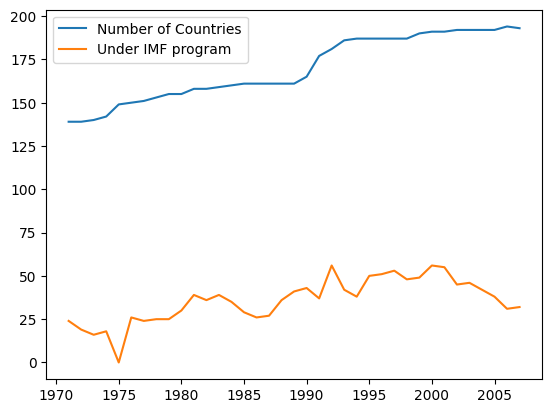

In [99]:
counts = imf.groupby('year').agg({
    'ccode_cow' : 'count',
    'imf_prog' : 'sum'
}).reset_index()

# total number of data points
num_cu = counts['ccode_cow'].sum()
print("Data points: " + str(num_cu))

# number of countries under an program each year
num_prog = counts['imf_prog'].sum()
print("Number under program: " + str(num_prog))

# Average country per year
avg_cu = counts['ccode_cow'].mean()
print('Average country per year: ' + str(avg_cu))

# Average country under program per year
avg_prog = counts['imf_prog'].mean()
print("Average countries under program per year: " + str(avg_prog))

# plot number of countries under program per year
plt.figure()
plt.plot(counts['year'], counts['ccode_cow'])
plt.plot(counts['year'], counts['imf_prog'])
plt.legend(['Number of Countries', 'Under IMF program'])
plt.show()


# vdem data

In [100]:
vdem_raw = pd.read_csv("Data/raw/vdem/V-Dem-CY-Full+Others-v15.csv")

C:\Users\flore\AppData\Local\Temp\ipykernel_43104\3091229396.py:1: DtypeWarning: Columns (364,365,366,399,804,836,837,924,1240,1257,1486,3094,3168,3169,3341,3342,3344,3345,3347,3350,3352) have mixed types. Specify dtype option on import or set low_memory=False.
  vdem_raw = pd.read_csv("Data/raw/vdem/V-Dem-CY-Full+Others-v15.csv")


## Clean vdem data

In [101]:
# select the variables we want
vdem_clean = vdem_raw[['year','country_text_id','country_id','COWcode','country_name','codingstart','codingend','v2x_polyarchy','v2x_regime_amb']]

# compute number of transitions to autocracy before

# keep country-years only between their start and end date
vdem_clean = vdem_clean[(vdem_clean['year'] >= vdem_clean['codingstart']) & (vdem_clean['year'] <= vdem_clean['codingend'])]

# add cow code to missing countries
vdem_clean.loc[vdem_clean['country_name']=='Zanzibar','COWcode'] = 511

# remove specific countries
countries = ['Palestine/West Bank', 'Palestine/Gaza', 'Somaliland', 'Hong Kong']
vdem_clean = vdem_clean[~vdem_clean['country_name'].isin(countries)]

# change some specific country code
vdem_clean.loc[vdem_clean['country_name'].str.contains('Yugoslavia',case=False,na=False),'country_text_id'] = 'YUG'

# remove NaN in polyarchy
vdem_clean = vdem_clean[~vdem_clean['v2x_polyarchy'].isna()]

# create lag
vdem_clean['v2x_polyarchy_l1'] = vdem_clean.groupby('country_id')['v2x_polyarchy'].shift(1)
vdem_clean['v2x_polyarchy_n1'] = vdem_clean.groupby('country_id')['v2x_polyarchy'].shift(-1)

vdem_clean

,year,country_text_id,country_id,COWcode,country_name,codingstart,codingend,v2x_polyarchy,v2x_regime_amb,v2x_polyarchy_l1,v2x_polyarchy_n1
0,1789,MEX,3,70.0,Mexico,1789,2024,0.028,NaN,NaN,0.028
1,1790,MEX,3,70.0,Mexico,1789,2024,0.028,NaN,0.028,0.028
2,1791,MEX,3,70.0,Mexico,1789,2024,0.028,NaN,0.028,0.028
3,1792,MEX,3,70.0,Mexico,1789,2024,0.028,NaN,0.028,0.028
4,1793,MEX,3,70.0,Mexico,1789,2024,0.028,NaN,0.028,0.028
...,...,...,...,...,...,...,...,...,...,...,...
27908,1857,SPD,373,NaN,Piedmont-Sardinia,1789,1861,0.205,NaN,0.205,0.206
27909,1858,SPD,373,NaN,Piedmont-Sardinia,1789,1861,0.206,NaN,0.205,0.206
27910,1859,SPD,373,NaN,Piedmont-Sardinia,1789,1861,0.206,NaN,0.206,0.210
27911,1860,SPD,373,NaN,Piedmont-Sardinia,1789,1861,0.210,NaN,0.206,0.210


In [102]:
# count previous transitions into autocracy for each country-year
vdem_aut = vdem_clean[vdem_clean['year'] >= 1946]

vdem_aut['is_autocracy'] = (vdem_aut['v2x_regime_amb'] < 4).astype(int)

def count_transitions(subdf):
    subdf = subdf.sort_values("year").copy()
    
    # Lag autocracy state
    subdf["is_autocracy_lag"] = subdf["is_autocracy"].shift(1).fillna(0)
    
    # Transition occurs if previous year was NOT autocracy, current year IS autocracy
    subdf["autocracy_transition"] = (
        (subdf["is_autocracy"] == 1) &
        (subdf["is_autocracy_lag"] == 0)
    ).astype(int)
    
    # Cumulative count since 1946
    subdf["num_aut_trans"] = subdf["autocracy_transition"].cumsum()

    # drop transition and lag
    subdf.drop(columns=['is_autocracy_lag','autocracy_transition'], inplace=True)
    
    return subdf

vdem = vdem_aut.groupby("COWcode", group_keys=False).apply(count_transitions)
vdem

C:\Users\flore\AppData\Local\Temp\ipykernel_43104\3644961524.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vdem_aut['is_autocracy'] = (vdem_aut['v2x_regime_amb'] < 4).astype(int)
C:\Users\flore\AppData\Local\Temp\ipykernel_43104\3644961524.py:26: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  vdem = vdem_aut.groupby("COWcode", group_keys=False).apply(count_transitions)


,year,country_text_id,country_id,COWcode,country_name,codingstart,codingend,v2x_polyarchy,v2x_regime_amb,v2x_polyarchy_l1,v2x_polyarchy_n1,is_autocracy,num_aut_trans
157,1946,MEX,3,70.0,Mexico,1789,2024,0.192,3.0,0.191,0.193,1,1
158,1947,MEX,3,70.0,Mexico,1789,2024,0.193,3.0,0.192,0.193,1,1
159,1948,MEX,3,70.0,Mexico,1789,2024,0.193,3.0,0.193,0.196,1,1
160,1949,MEX,3,70.0,Mexico,1789,2024,0.196,3.0,0.193,0.197,1,1
161,1950,MEX,3,70.0,Mexico,1789,2024,0.197,3.0,0.196,0.197,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26509,2020,ZZB,236,511.0,Zanzibar,1856,2024,0.271,3.0,0.266,0.285,1,1
26510,2021,ZZB,236,511.0,Zanzibar,1856,2024,0.285,3.0,0.271,0.294,1,1
26511,2022,ZZB,236,511.0,Zanzibar,1856,2024,0.294,3.0,0.285,0.298,1,1
26512,2023,ZZB,236,511.0,Zanzibar,1856,2024,0.298,3.0,0.294,0.299,1,1


## Summarize vdem data

Data points: 6060
Average country per year: 163.78378378378378
Average polyarchy: 0.4002149579335522
Minimum avg polyarchy: 0.009
Maximum avg polyarchy: 0.923


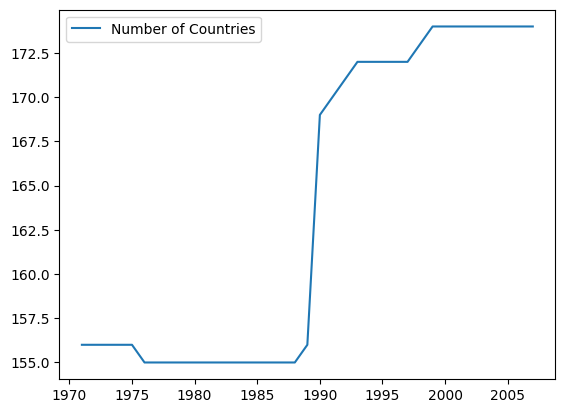

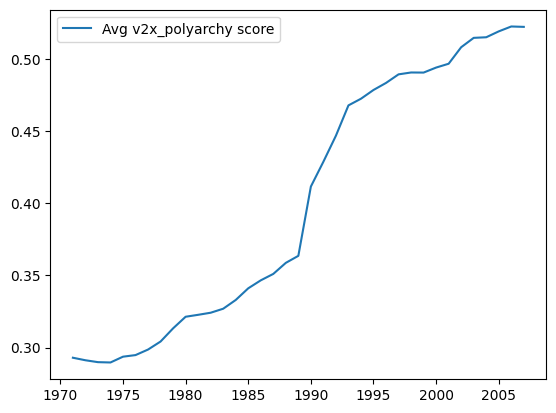

In [103]:
# keep data only from 1960 to 2017
vdem = vdem[(vdem['year'] >= start_date) & (vdem['year'] <= end_date)]

vdem_count = vdem.groupby('year').agg({
    "country_id":"count",
    "v2x_polyarchy":"mean"
}).reset_index()

# total number of data points
num_cu = vdem_count['country_id'].sum()
print("Data points: " + str(num_cu))

# Average country per year
avg_cu = vdem_count['country_id'].mean()
print('Average country per year: ' + str(avg_cu))

# Average polyarchy
avg_prog = vdem_count['v2x_polyarchy'].mean()
print("Average polyarchy: " + str(avg_prog))

# min and max  polyarchy
min_avg = vdem['v2x_polyarchy'].min()
max_avg = vdem['v2x_polyarchy'].max()
print("Minimum avg polyarchy: " + str(min_avg))
print("Maximum avg polyarchy: " + str(max_avg))

# plot number of countries per year
plt.figure()
plt.plot(vdem_count['year'], vdem_count['country_id'])
plt.legend(['Number of Countries'])
plt.show()

# plot average polyarchy per year
plt.figure()
plt.plot(vdem_count['year'], vdem_count['v2x_polyarchy'])
plt.legend(['Avg v2x_polyarchy score'])
plt.show()

# Merge IMF and vdem data

In [135]:
# merge IMF and vdem data
imf_vdem = pd.merge(imf, vdem, left_on=['year','ccode_cow'], right_on=['year', 'COWcode'], how='inner',)

# keep relevant columns
imf_vdem = imf_vdem[['year','ccode_cow','country_text_id','cname_imf','agree_count','imf_prog',
                     'v2x_polyarchy','v2x_polyarchy_l1','v2x_polyarchy_n1','v2x_regime_amb','is_autocracy','num_aut_trans']]

imf_vdem

,year,ccode_cow,country_text_id,cname_imf,agree_count,imf_prog,v2x_polyarchy,v2x_polyarchy_l1,v2x_polyarchy_n1,v2x_regime_amb,is_autocracy,num_aut_trans
0,1971.0,700.0,AFG,Afghanistan,1.0,1,0.163,0.163,0.157,0.0,1,1
1,1972.0,700.0,AFG,Afghanistan,0.0,0,0.157,0.163,0.153,0.0,1,1
2,1973.0,700.0,AFG,Afghanistan,0.0,0,0.153,0.157,0.104,0.0,1,1
3,1974.0,700.0,AFG,Afghanistan,1.0,1,0.104,0.153,0.105,0.0,1,1
4,1975.0,700.0,AFG,Afghanistan,0.0,0,0.105,0.104,0.105,0.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5838,2003.0,552.0,ZWE,Zimbabwe,0.0,0,0.268,0.268,0.256,3.0,1,2
5839,2004.0,552.0,ZWE,Zimbabwe,0.0,0,0.256,0.268,0.255,3.0,1,2
5840,2005.0,552.0,ZWE,Zimbabwe,0.0,0,0.255,0.256,0.256,3.0,1,2
5841,2006.0,552.0,ZWE,Zimbabwe,0.0,0,0.256,0.255,0.256,3.0,1,2


### run quick regression

In [136]:
regdata = imf_vdem[['v2x_polyarchy','imf_prog','v2x_polyarchy_l1']].dropna()
y = regdata['v2x_polyarchy']
X = sm.add_constant(regdata[['imf_prog','v2x_polyarchy_l1']])
reg = sm.OLS(y, X).fit()

reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          v2x_polyarchy   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                 1.148e+05
Date:                Wed, 26 Nov 2025   Prob (F-statistic):               0.00
Time:                        05:37:41   Log-Likelihood:                 9724.2
No. Observations:                5838   AIC:                        -1.944e+04
Df Residuals:                    5835   BIC:                        -1.942e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0098      0.001      9.015      0.000       0.008       0.012
imf_prog             0.0037      0.001      2.588      0.010       0.001       0.007
v2x_polyarchy_l1     0.9889      0.002    478.974      0.000       0.985       0.993
==============================================================================
Omnibus:                     5054.410   Durbin-Watson:                   1.562
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           647218.230
Skew:                           3.555   Prob(JB):                         0.00
Kurtosis:                      54.090   Cond. No.                         4.19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Controls

## Autocratic regime type dummies

In [137]:
gwf_aut_raw = pd.read_excel("Data/raw/GWF Autocratic Regimes 1.2/GWF Autocratic Regimes.xlsx", sheet_name='TSCS data')
gwf_aut_raw

,cowcode,year,gwf_country,gwf_casename,gwf_startdate,gwf_enddate,gwf_spell,gwf_duration,gwf_fail,gwf_fail_subsregime,gwf_fail_type,gwf_fail_violent,gwf_regimetype,gwf_party,gwf_personal,gwf_military,gwf_monarch
0,40,1953,Cuba,Cuba 52-59,1952-10-03 00:00:00,1959-01-01 00:00:00,7,1,0,0,0,0,personal,0,1,0,0
1,40,1954,Cuba,Cuba 52-59,1952-10-03 00:00:00,1959-01-01 00:00:00,7,2,0,0,0,0,personal,0,1,0,0
2,40,1955,Cuba,Cuba 52-59,1952-10-03 00:00:00,1959-01-01 00:00:00,7,3,0,0,0,0,personal,0,1,0,0
3,40,1956,Cuba,Cuba 52-59,1952-10-03 00:00:00,1959-01-01 00:00:00,7,4,0,0,0,0,personal,0,1,0,0
4,40,1957,Cuba,Cuba 52-59,1952-10-03 00:00:00,1959-01-01 00:00:00,7,5,0,0,0,0,personal,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4586,850,1995,Indonesia,Indonesia 66-99,1966-11-03 00:00:00,1999-07-06 00:00:00,33,29,0,0,0,0,party-personal-military,1,0,0,0
4587,850,1996,Indonesia,Indonesia 66-99,1966-11-03 00:00:00,1999-07-06 00:00:00,33,30,0,0,0,0,party-personal-military,1,0,0,0
4588,850,1997,Indonesia,Indonesia 66-99,1966-11-03 00:00:00,1999-07-06 00:00:00,33,31,0,0,0,0,party-personal-military,1,0,0,0
4589,850,1998,Indonesia,Indonesia 66-99,1966-11-03 00:00:00,1999-07-06 00:00:00,33,32,0,0,0,0,party-personal-military,1,0,0,0


### clean gwf data

In [107]:
gwf_aut = gwf_aut_raw.copy()

# keep years between start and end
gwf_aut['gwf_startdate'] = pd.to_datetime(gwf_aut['gwf_startdate'])
gwf_aut['gwf_enddate'] = pd.to_datetime(gwf_aut['gwf_enddate'])
gwf_aut = gwf_aut[(gwf_aut['year'] >= gwf_aut['gwf_startdate'].dt.year) 
                      & (gwf_aut['year'] <= gwf_aut['gwf_enddate'].dt.year)]

# keep relevant columnns
gwf_aut = gwf_aut[['year','cowcode','gwf_military','gwf_monarch']]

# rename cow code column
gwf_aut.rename(columns={'cowcode':'ccode_cow'}, inplace=True)

gwf_aut

,year,ccode_cow,gwf_military,gwf_monarch
0,1953,40,0,0
1,1954,40,0,0
2,1955,40,0,0
3,1956,40,0,0
4,1957,40,0,0
...,...,...,...,...
4586,1995,850,0,0
4587,1996,850,0,0
4588,1997,850,0,0
4589,1998,850,0,0


### merge gwf data to dataset

In [138]:
# merge on year and cow code
imf_vdem_ctrl = pd.merge(imf_vdem, gwf_aut, on=['year','ccode_cow'], how='left')

# NA values for the gwf dummies mean they are democracies. Replace NA for 0
imf_vdem_ctrl.loc[imf_vdem_ctrl['gwf_military'].isna(),'gwf_military'] = 0
imf_vdem_ctrl.loc[imf_vdem_ctrl['gwf_monarch'].isna(),'gwf_monarch'] = 0

imf_vdem_ctrl

,year,ccode_cow,country_text_id,cname_imf,agree_count,imf_prog,v2x_polyarchy,v2x_polyarchy_l1,v2x_polyarchy_n1,v2x_regime_amb,is_autocracy,num_aut_trans,gwf_military,gwf_monarch
0,1971.0,700.0,AFG,Afghanistan,1.0,1,0.163,0.163,0.157,0.0,1,1,0.0,1.0
1,1972.0,700.0,AFG,Afghanistan,0.0,0,0.157,0.163,0.153,0.0,1,1,0.0,1.0
2,1973.0,700.0,AFG,Afghanistan,0.0,0,0.153,0.157,0.104,0.0,1,1,0.0,1.0
3,1974.0,700.0,AFG,Afghanistan,1.0,1,0.104,0.153,0.105,0.0,1,1,0.0,0.0
4,1975.0,700.0,AFG,Afghanistan,0.0,0,0.105,0.104,0.105,0.0,1,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5838,2003.0,552.0,ZWE,Zimbabwe,0.0,0,0.268,0.268,0.256,3.0,1,2,0.0,0.0
5839,2004.0,552.0,ZWE,Zimbabwe,0.0,0,0.256,0.268,0.255,3.0,1,2,0.0,0.0
5840,2005.0,552.0,ZWE,Zimbabwe,0.0,0,0.255,0.256,0.256,3.0,1,2,0.0,0.0
5841,2006.0,552.0,ZWE,Zimbabwe,0.0,0,0.256,0.255,0.256,3.0,1,2,0.0,0.0


## Draw data from World Bank

In [139]:
indicators = {
    "TX.VAL.FUEL.ZS.UN": "wbi_fuel_export_share",
    "FI.RES.TOTL.CD": "wbi_total_reserves",
    "NY.GNP.MKTP.CD": "wbi_gni",
    "NY.GDP.MKTP.KD": "wbi_gdp",
    "NY.GDP.PCAP.KD": "wbi_gdp_pc",
    "PA.NUS.FCRF": "wbi_xr",
    "DT.DOD.DECT.CD":"wbi_total_debt",
    "DT.DOD.DECT.GN.ZS":"wbi_total_debt2gni"
}

wbi_raw = wbdata.get_dataframe(indicators).reset_index()
wbi_raw

,country,date,wbi_fuel_export_share,wbi_total_reserves,wbi_gni,wbi_gdp,wbi_gdp_pc,wbi_xr,wbi_total_debt,wbi_total_debt2gni
0,Africa Eastern and Southern,2024,NaN,NaN,1.176254e+12,1.089514e+12,1416.250369,NaN,NaN,NaN
1,Africa Eastern and Southern,2023,25.423993,NaN,1.108161e+12,1.060181e+12,1412.625384,NaN,NaN,NaN
2,Africa Eastern and Southern,2022,27.007813,NaN,1.161036e+12,1.040502e+12,1421.797169,NaN,NaN,NaN
3,Africa Eastern and Southern,2021,23.711281,NaN,1.061080e+12,1.004774e+12,1409.040699,NaN,NaN,NaN
4,Africa Eastern and Southern,2020,23.344011,NaN,9.152252e+11,9.609218e+11,1383.724119,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
17285,Zimbabwe,1964,NaN,NaN,7.701993e+08,4.929107e+09,1140.995313,0.000714,NaN,NaN
17286,Zimbabwe,1963,NaN,NaN,8.467316e+08,4.984241e+09,1190.727981,0.000714,NaN,NaN
17287,Zimbabwe,1962,NaN,NaN,8.490359e+08,4.691300e+09,1156.643827,0.000714,NaN,NaN
17288,Zimbabwe,1961,NaN,NaN,8.614727e+08,4.624956e+09,1176.713594,0.000714,NaN,NaN


### Get country code to merge on country name

In [140]:
wbi_codes = pd.DataFrame(wbdata.get_countries())

# get region for each country
wbi_codes['wbi_region_name'] = wbi_codes['region'].apply(lambda x: x['value'])

# keep only relevant columns
wbi_codes = wbi_codes[['id','name','wbi_region_name']]

# rename country name column
wbi_codes.rename(columns={'name':'country'}, inplace=True)

wbi_codes

,id,country,wbi_region_name
0,ABW,Aruba,Latin America & Caribbean
1,AFE,Africa Eastern and Southern,Aggregates
2,AFG,Afghanistan,"Middle East, North Africa, Afghanistan & Pakistan"
3,AFR,Africa,Aggregates
4,AFW,Africa Western and Central,Aggregates
...,...,...,...
291,XZN,Sub-Saharan Africa excluding South Africa and ...,Aggregates
292,YEM,"Yemen, Rep.","Middle East, North Africa, Afghanistan & Pakistan"
293,ZAF,South Africa,Sub-Saharan Africa
294,ZMB,Zambia,Sub-Saharan Africa


In [141]:
# merge country codes with data
wbi = pd.merge(wbi_raw,wbi_codes, on='country', how='inner')

# rename columns
wbi.rename(columns={'date':'year', 'id':'wbi_id'}, inplace=True)

# make year as in
wbi['year'] = wbi['year'].astype(int)

# compute additional variables
wbi['wbi_total_reserves2gni'] = wbi['wbi_total_reserves']/wbi['wbi_gni']
wbi['l_wbi_gdp_pc'] = np.log(wbi['wbi_gdp_pc'])
wbi['wbi_total_debt2gdp'] = wbi['wbi_total_debt']/wbi['wbi_gdp']
wbi['wbi_xr_dep'] = wbi.groupby('wbi_id')['wbi_xr'].pct_change()


# create lags
econ_var = wbi.columns[~wbi.columns.isin(['year','country','wbi_id','wbi_region_name'])]
for v in econ_var:
    wbi[v+"_l1"] = wbi.groupby('country')[v].shift(1)

imf_vdem_ctrl2 = pd.merge(imf_vdem_ctrl, wbi, left_on=['year','country_text_id'], right_on=['year','wbi_id'], how='left')

C:\Users\flore\AppData\Local\Temp\ipykernel_43104\371502841.py:14: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  wbi['wbi_xr_dep'] = wbi.groupby('wbi_id')['wbi_xr'].pct_change()


## Penn World Table

In [114]:
pwt_raw = pd.read_excel('Data/raw/pwt110.xlsx', sheet_name='Data')
pwt_raw

,countrycode,country,currency_unit,year,rgdpe,rgdpo,pop,emp,avh,hc,...,csh_x,csh_m,csh_r,pl_c,pl_i,pl_g,pl_x,pl_m,pl_n,pl_k
0,ABW,Aruba,Aruban Guilder,1950,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ABW,Aruba,Aruban Guilder,1951,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ABW,Aruba,Aruban Guilder,1952,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ABW,Aruba,Aruban Guilder,1953,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ABW,Aruba,Aruban Guilder,1954,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13685,ZWE,Zimbabwe,US Dollar,2019,46541.140625,45106.468750,15.271368,5.272343,1903.71,2.713408,...,0.189066,-0.242234,0.038880,0.501244,0.534841,0.345942,0.505318,0.441230,0.339268,1.346716
13686,ZWE,Zimbabwe,US Dollar,2020,45985.085938,45983.898438,15.526888,5.206007,1889.45,2.746586,...,0.110438,-0.165574,0.029654,0.500685,0.519637,0.290690,0.772591,0.680202,0.324105,1.353769
13687,ZWE,Zimbabwe,US Dollar,2021,45625.347656,44440.199219,15.797210,5.298346,2011.57,2.770661,...,0.172298,-0.279770,0.024442,0.616105,0.549380,0.301370,0.558099,0.497615,0.347739,1.064607
13688,ZWE,Zimbabwe,US Dollar,2022,50148.527344,48054.238281,16.069056,5.344455,2172.04,2.795292,...,0.220504,-0.391468,0.021712,0.660731,0.478931,0.280778,0.487665,0.432867,0.301817,1.006796


In [142]:
# keep relevant columns
pwt = pwt_raw[['year','countrycode','rgdpe','pop','emp','pl_m','pl_c','xr']]

# compute other variables
pwt['rgdpe_pc'] = pwt['rgdpe']/pwt['pop']
pwt['l_rgdpe_pc'] = np.log(pwt['rgdpe_pc'])
pwt['l_pl_c'] = np.log(pwt['pl_c'])
pwt['l_pl_m'] = np.log(pwt['pl_m'])
pwt['emp_rate'] = pwt['emp']/pwt['pop']

pwt['ld_rgdpe_pc'] = pwt.groupby('countrycode')['l_rgdpe_pc'].diff()
pwt['ld_pl_c'] = pwt.groupby('countrycode')['l_pl_c'].diff()
pwt['ld_pl_m'] = pwt.groupby('countrycode')['l_pl_m'].diff()

pwt.drop(columns=['l_pl_c','l_pl_m'], inplace=True)

# compute lags of variables
for c in pwt.columns[2:]:
    pwt[c+"_l1"] = pwt.groupby('countrycode')[c].shift(1)

# compute growth rates

# merge relevant columns with dataset
imf_vdem_ctrl3 = pd.merge(imf_vdem_ctrl2,pwt,left_on=['year','country_text_id'],right_on=['year','countrycode'],how='left')

C:\Users\flore\AppData\Local\Temp\ipykernel_43104\871368746.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pwt['rgdpe_pc'] = pwt['rgdpe']/pwt['pop']
C:\Users\flore\AppData\Local\Temp\ipykernel_43104\871368746.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pwt['l_rgdpe_pc'] = np.log(pwt['rgdpe_pc'])
C:\Users\flore\AppData\Local\Temp\ipykernel_43104\871368746.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

## Oil exporter

In [143]:
# =======================================
# 2. OPEC membership list (start,end years)
# =======================================

opec_membership = {
    "ALG": (1969, 2024),
    "ANG": (2007, 2023),
    "ECU": (1973, 1992), 
    "IRN": (1960, 2024),
    "IRQ": (1960, 2024),
    "KWT": (1960, 2024),
    "LBY": (1962, 2024),
    "NGA": (1971, 2023),
    "QAT": (1961, 2019),
    "SAU": (1960, 2024),
    "ARE": (1967, 2024),
    "VEN": (1960, 2024),
}

def opec_dummy(row):
    iso = row["country_text_id"]
    yr = row["year"]
    if iso in opec_membership:
        start, end = opec_membership[iso]
        return int(start <= yr <= end)
    return 0


# =======================================
# 3. IMF WEO “Oil Exporter” classification
# =======================================

weo_oil_exporters = [
    "SAU","IRN","IRQ","KWT","ARE","QAT",
    "RUS","KAZ","AZE",
    "NGA","AGO","GAB",
    "VEN","ECU","MEX"
]

def weo_dummy(iso):
    return 1 if iso in weo_oil_exporters else 0


# =======================================
# 4. Construct the oil-exporter variable
# =======================================

# WDI rule: Fuel exports >= 33%
imf_vdem_ctrl3["oil_from_wbi"] = (imf_vdem_ctrl3["wbi_fuel_export_share"] >= 33).astype(int)

# OPEC fallback
imf_vdem_ctrl3["opec_oil"] = imf_vdem_ctrl3.apply(opec_dummy, axis=1)

# WEO fallback
imf_vdem_ctrl3["weo_oil"] = imf_vdem_ctrl3["country_text_id"].apply(weo_dummy)

# Final oil-exporter dummy
imf_vdem_ctrl3["oil_exporter"] = imf_vdem_ctrl3[["oil_from_wbi","opec_oil","weo_oil"]].max(axis=1)

# drop the three rules
imf_vdem_ctrl3.drop(columns=['oil_from_wbi','opec_oil','weo_oil'], inplace=True)


## currency crash

In [144]:
# import imf exchange rate data
imf_xr = pd.read_csv("Data/raw/imf data/imf_xr.csv")

# rename columns
imf_xr.rename(columns={'TIME_PERIOD':'year','OBS_VALUE':'imf_xr','COUNTRY.ID':'country_text_id'}, inplace=True)

# compute depreciation rate and change in depreciation rate
imf_xr = imf_xr.sort_values(['COUNTRY','year'])
imf_xr['imf_xr_dep'] = imf_xr.groupby('COUNTRY')['imf_xr'].pct_change()
imf_xr['imf_xr_dep_acc'] = imf_xr.groupby('COUNTRY')['imf_xr_dep'].diff()

# create dummy 1 if country in crash
imf_xr['imf_curr_crash'] = ((imf_xr['imf_xr_dep'] >= 0.3) & (imf_xr['imf_xr_dep_acc'] >= 0.1)).astype(int)

# keep only relevant columns
imf_xr.drop(columns=['INDICATOR.ID','INDICATOR'],inplace=True)

# change some country codes to match dataset
imf_xr.loc[(imf_xr['COUNTRY']=='Czechoslovakia'),'country_text_id'] = "CZE"
imf_xr.loc[(imf_xr['COUNTRY']=='Yemen Arab Republic'),'country_text_id'] = "YEM"
imf_xr.loc[(imf_xr['COUNTRY']=='Yugoslavia'),'country_text_id'] = "YUG"

imf_xr

C:\Users\flore\AppData\Local\Temp\ipykernel_43104\1557348951.py:9: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  imf_xr['imf_xr_dep'] = imf_xr.groupby('COUNTRY')['imf_xr'].pct_change()


,country_text_id,COUNTRY,year,imf_xr,imf_xr_dep,imf_xr_dep_acc,imf_curr_crash
9897,AFG,"Afghanistan, Islamic Republic of",1955,16.9260,NaN,NaN,0
9898,AFG,"Afghanistan, Islamic Republic of",1956,16.9260,0.000000,NaN,0
9899,AFG,"Afghanistan, Islamic Republic of",1957,16.9260,0.000000,0.000000,0
9900,AFG,"Afghanistan, Islamic Republic of",1958,16.9260,0.000000,0.000000,0
9901,AFG,"Afghanistan, Islamic Republic of",1959,16.9260,0.000000,0.000000,0
...,...,...,...,...,...,...,...
536,ZWE,Zimbabwe,2020,81.7866,3.875970,4.875967,1
537,ZWE,Zimbabwe,2021,108.6660,0.328653,-3.547317,0
538,ZWE,Zimbabwe,2022,684.3390,5.297637,4.968984,1
539,ZWE,Zimbabwe,2023,6104.7226,7.920612,2.622975,1


In [145]:
# merge with dataset
imf_vdem_ctrl4 = imf_vdem_ctrl3.merge(imf_xr, on=['year','country_text_id'], how='left')

# fill empty dummy rows with 0 after checking manually
imf_vdem_ctrl4['imf_curr_crash'].fillna(value=0,inplace=True)

# remove country column
imf_vdem_ctrl4.drop(columns=['COUNTRY'], inplace=True)

C:\Users\flore\AppData\Local\Temp\ipykernel_43104\2961048754.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  imf_vdem_ctrl4['imf_curr_crash'].fillna(value=0,inplace=True)


## Political violence index

In [146]:
mepv_raw = pd.read_excel('Data/raw/mepv/MEPV2012ex.xls')

# keep only relevant columns
mepv = mepv_raw[['SCODE','CCODE','COUNTRY','YEAR','ACTOTAL']]

# rename columns
mepv.rename(columns={'CCODE':'ccode_cow','YEAR':'year'}, inplace=True)

# change some country codes to match with dataset
mepv.loc[mepv['SCODE']=='SER','ccode_cow'] = 345
mepv.loc[mepv['SCODE']=='VIE','ccode_cow'] = 816

mepv

C:\Users\flore\AppData\Local\Temp\ipykernel_43104\3124070848.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mepv.rename(columns={'CCODE':'ccode_cow','YEAR':'year'}, inplace=True)


,SCODE,ccode_cow,COUNTRY,year,ACTOTAL
0,AFG,700,Afghanistan,1946,0.0
1,AFG,700,Afghanistan,1947,0.0
2,AFG,700,Afghanistan,1948,0.0
3,AFG,700,Afghanistan,1949,0.0
4,AFG,700,Afghanistan,1950,0.0
...,...,...,...,...,...
9041,ZIM,552,Zimbabwe,2008,0.0
9042,ZIM,552,Zimbabwe,2009,0.0
9043,ZIM,552,Zimbabwe,2010,0.0
9044,ZIM,552,Zimbabwe,2011,0.0


In [147]:
# merge on dataset
imf_vdem_ctrl5 = imf_vdem_ctrl4.merge(mepv, on=['year','ccode_cow'], how='left')

# fill missing with 0 (after checking manually)
imf_vdem_ctrl5['ACTOTAL'] = imf_vdem_ctrl5['ACTOTAL'].fillna(value=0)

# get rid of useless columns
imf_vdem_ctrl5.drop(columns=['SCODE','COUNTRY'], inplace=True)

## Region dummies

In [148]:
# assign region to regionless countries
imf_vdem_ctrl5.loc[imf_vdem_ctrl5['cname_imf']=='Republic of Vietnam','wbi_region_name'] = "East Asia & Pacific"
imf_vdem_ctrl5.loc[imf_vdem_ctrl5['cname_imf']=='Taiwan','wbi_region_name'] = "East Asia & Pacific"
imf_vdem_ctrl5.loc[imf_vdem_ctrl5['cname_imf']=="Yemen People's Republic",'wbi_region_name'] = "Middle East, North Africa, Afghanistan & Pakistan"
imf_vdem_ctrl5.loc[imf_vdem_ctrl5['cname_imf']=="Zanzibar",'wbi_region_name'] = "Sub-Saharan Africa "
imf_vdem_ctrl5.loc[imf_vdem_ctrl5['cname_imf']=="Zimbabwe",'wbi_region_name'] = "Sub-Saharan Africa "
imf_vdem_ctrl5.loc[imf_vdem_ctrl5['cname_imf']=="Zimbabwe",'wbi_region_name'] = "Sub-Saharan Africa "

# assign Post-Communist as region to post communist countries
post_communist_countries = ['Albania','Armenia','Azerbaijan','Belarus','Bosnia and Herzegovina','Bulgaria','Croatia',
                            'Czech Republic','Czechoslovakia','Estonia','Georgia','German Democratic Republic',
                            'Hungary','Kazakhstan','Kosovo','Kyrgyz Republic','Latvia','Lithuania','Macedonia','Moldova',
                            'Montenegro','Poland','Romania','Russia','Serbia','Slovakia','Slovenia','Tajikistan',
                            'Turkmenistan','Ukraine','Uzbekistan','Yugoslavia','German Democratic Republic']

imf_vdem_ctrl5.loc[imf_vdem_ctrl5['cname_imf'].isin(post_communist_countries),'wbi_region_name'] = 'Post Communist'

# create region dummies
region_dummies = pd.get_dummies(imf_vdem_ctrl5['wbi_region_name'], prefix='region').astype(int)
region_dummies.drop(columns=['region_North America'], inplace=True)
region_dummies_cols = list(region_dummies.columns)

## Year dummies

In [149]:
year_dummies = pd.get_dummies(imf_vdem_ctrl5['year']).astype(int)
year_dummies = year_dummies.iloc[:,1:]
year_dummies_cols = list(year_dummies.columns)

## Combine dummies with dataset

In [150]:
imf_vdem_ctrl6 = pd.concat([imf_vdem_ctrl5,region_dummies,year_dummies], axis=1)

# Clean final dataset

In [151]:
imf_vdem_ctrl6.drop(columns=['v2x_regime_amb','is_autocracy','country','imf_xr_dep_acc','countrycode'], inplace=True)

In [127]:
imf_vdem_ctrl5.columns

Index(['year', 'ccode_cow', 'country_text_id', 'cname_imf', 'agree_count',
       'imf_prog', 'v2x_polyarchy', 'v2x_polyarchy_l1', 'v2x_regime_amb',
       'is_autocracy', 'num_aut_trans', 'gwf_military', 'gwf_monarch',
       'country', 'wbi_fuel_export_share', 'wbi_total_reserves', 'wbi_gni',
       'wbi_gdp', 'wbi_gdp_pc', 'wbi_xr', 'wbi_total_debt',
       'wbi_total_debt2gni', 'wbi_id', 'wbi_region_name',
       'wbi_total_reserves2gni', 'l_wbi_gdp_pc', 'wbi_total_debt2gdp',
       'wbi_xr_dep', 'wbi_fuel_export_share_l1', 'wbi_total_reserves_l1',
       'wbi_gni_l1', 'wbi_gdp_l1', 'wbi_gdp_pc_l1', 'wbi_xr_l1',
       'wbi_total_debt_l1', 'wbi_total_debt2gni_l1',
       'wbi_total_reserves2gni_l1', 'l_wbi_gdp_pc_l1', 'wbi_total_debt2gdp_l1',
       'wbi_xr_dep_l1', 'countrycode', 'rgdpe', 'pop', 'emp', 'pl_m', 'pl_c',
       'xr', 'rgdpe_pc', 'l_rgdpe_pc', 'emp_rate', 'ld_rgdpe_pc', 'ld_pl_c',
       'ld_pl_m', 'rgdpe_l1', 'pop_l1', 'emp_l1', 'pl_m_l1', 'pl_c_l1',
       'xr_l1', 

In [171]:
paper_vars = ['v2x_polyarchy','imf_prog','agree_count','num_aut_trans','gwf_military','gwf_monarch','wbi_total_reserves2gni_l1',
              'l_rgdpe_pc_l1','ld_rgdpe_pc_l1','oil_exporter','imf_curr_crash','ACTOTAL']
paper_vars = paper_vars + region_dummies_cols + year_dummies_cols

lower_inc_countries = imf_vdem_ctrl6[~imf_vdem_ctrl6['wbi_region_name'].isin(['North America','Europe & Central Asia'])]
paper_data = imf_vdem_ctrl6[paper_vars].dropna(how='any')
paper_data

,v2x_polyarchy,imf_prog,agree_count,num_aut_trans,gwf_military,gwf_monarch,wbi_total_reserves2gni_l1,l_rgdpe_pc_l1,ld_rgdpe_pc_l1,oil_exporter,...,1998.0,1999.0,2000.0,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0
58,0.421,0,0.0,1,0.0,0.0,0.136571,8.053667,-0.216224,0,...,0,0,0,0,0,0,0,0,0,0
59,0.417,1,1.0,1,0.0,0.0,0.118008,7.803292,-0.250374,0,...,0,0,0,0,0,0,0,0,0,0
60,0.417,1,1.0,1,0.0,0.0,0.089971,8.011092,0.207800,0,...,0,0,0,0,0,0,0,0,0,0
61,0.427,1,1.0,1,0.0,0.0,0.097810,8.199589,0.188497,0,...,0,0,0,0,0,0,0,0,0,0
62,0.386,1,1.0,1,0.0,0.0,0.146086,8.284498,0.084909,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5838,0.268,0,0.0,2,0.0,0.0,0.058879,8.514975,0.069165,0,...,0,0,0,0,0,1,0,0,0,0
5839,0.256,0,0.0,2,0.0,0.0,0.024380,8.281488,-0.233486,0,...,0,0,0,0,0,0,1,0,0,0
5840,0.255,0,0.0,2,0.0,0.0,0.045087,7.468777,-0.812712,0,...,0,0,0,0,0,0,0,1,0,0
5841,0.256,0,0.0,2,0.0,0.0,0.055199,6.412383,-1.056394,1,...,0,0,0,0,0,0,0,0,1,0


# Summarize final data set

In [173]:
data = paper_data

total_cu = len(data)
total_t = len(data[data['imf_prog']==1])
total_c = total_cu - total_t
print("Total number of datapoints: " + str(total_cu))
print("Total number of treated: " + str(total_t) + " (" + str(round(100*total_t/total_cu,2)) + "%)")
print("Total number of controls: " + str(total_c) + " (" + str(round(100*total_c/total_cu,2)) + "%)")

Total number of datapoints: 4573
Total number of treated: 1103 (24.12%)
Total number of controls: 3470 (75.88%)


In [183]:
data.to_csv('data.csv',index=False)

# Model

## Orthogonal Doubly-Robust Estimator

In [130]:
def dr_learner(X, t, y):
    n = len(y)
    n_split = 3

    mu0_all = np.zeros(n)
    mu1_all = np.zeros(n)
    e_all = np.zeros(n)

    kf = skl.model_selection.KFold(n_splits=n_split, shuffle=True, random_state=0)
    for train_idx, test_idx in kf.split(X):
        X_tr, X_te = X[train_idx], X[test_idx]
        y_tr = y[train_idx]
        t_tr = t[train_idx]

        # Strong RF models for nuisance functions
        mu0 = skl.ensemble.RandomForestRegressor(
            n_estimators=200, max_depth=None, min_samples_leaf=5, random_state=0
        )
        mu1 = skl.ensemble.RandomForestRegressor(
            n_estimators=200, max_depth=None, min_samples_leaf=5, random_state=0
        )
        mu0.fit(X_tr[t_tr == 0], y_tr[t_tr == 0])
        mu1.fit(X_tr[t_tr == 1], y_tr[t_tr == 1])
        mu0_all[test_idx] = mu0.predict(X_te)
        mu1_all[test_idx] = mu1.predict(X_te)

        # Propensity
        e_model = skl.linear_model.LogisticRegression(max_iter=500)
        e_model.fit(X_tr, t_tr)
        e_all[test_idx] = np.clip(e_model.predict_proba(X_te)[:, 1], 0.05, 0.95)

    # Doubly robust pseudo-outcome (orthogonal score)
    mu_t = mu0_all * (1 - t) + mu1_all * t
    phi = (mu1_all - mu0_all) + (t - e_all) * (y - mu_t) / (e_all * (1 - e_all))
    
    # Clip extreme values for numerical stability
    phi = np.clip(phi, -10, 10)

    # Final CATE model (rich RF)
    tau_model = skl.ensemble.RandomForestRegressor(
        n_estimators=300, max_depth=None, min_samples_leaf=5, random_state=0
    )
    tau_model.fit(X, phi)
    ol_tau_hat = tau_model.predict(X)
    return ol_tau_hat



## Run model

In [168]:
y = data.iloc[:,0]
t = data.iloc[:,1]
X = data.iloc[:,2:].to_numpy()
tau_hat = dr_learner(X,t,y)
tau_hat

array([0.04543426, 0.02259409, 0.08814655, ..., 0.04145132, 0.02132105,
       0.06221403], shape=(4573,))

In [179]:
full_data =imf_vdem_ctrl6.iloc[data.index]
full_data['te'] = tau_hat


att = full_data[full_data['imf_prog']==1]['te'].mean()
print(att)
atc = full_data[full_data['imf_prog']==0]['te'].mean()
print(atc)
ate = tau_hat.mean()
print(ate)

0.03911810722772885
0.026456825034176647
0.02951070525711303


C:\Users\flore\AppData\Local\Temp\ipykernel_43104\711620894.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_data['te'] = tau_hat


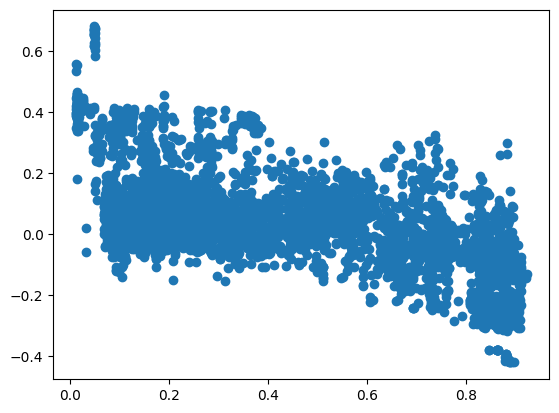

In [ ]:
plt.scatter(full_data['v2x_polyarchy_l1'], tau_hat)

In [ ]:
counts = full_data.groupby('year').agg({
    'ccode_cow' : 'count',
    'imf_prog' : 'sum'
}).reset_index()

# total number of data points
num_cu = counts['ccode_cow'].sum()
print("Data points: " + str(num_cu))

# number of countries under an program each year
num_prog = counts['imf_prog'].sum()
print("Number under program: " + str(num_prog))

# Average country per year
avg_cu = counts['ccode_cow'].mean()
print('Average country per year: ' + str(avg_cu))

# Average country under program per year
avg_prog = counts['imf_prog'].mean()
print("Average countries under program per year: " + str(avg_prog))

# plot number of countries under program per year
plt.figure()
plt.plot(counts['year'], counts['ccode_cow'])
plt.plot(counts['year'], counts['imf_prog'])
plt.legend(['Number of Countries', 'Under IMF program'])
plt.show()


## Bootstrap for confidence interval

In [787]:
def bootstrap(data,B,alpha):
    n = len(data)
    y = data.iloc[:,0].to_numpy()
    t = data.iloc[:,1].to_numpy()
    X = data.iloc[:,2:].to_numpy()

    cate_boot= np.zeros((B,n))

    for b in range(B):
        idx = np.random.choice(n, n, replace=True)
        X_b = X[idx]
        t_b = t[idx]
        y_b = y[idx]
        cate_boot[b] = dr_learner(X_b,t_b,y_b)

    lower = np.percentile(cate_boot,100*alpha/2, axis=0)
    upper = np.percentile(cate_boot,100*(1-alpha/2), axis=0)

    return cate_boot, lower, upper

In [788]:
_,lower,upper = bootstrap(data,100,0.05)

In [802]:
results_ci = np.vstack((tau_hat,lower,upper)).T
results_ci = pd.DataFrame(results_ci, columns=['CATE','Lower','Upper'])
results_ci['valid'] = (~((results_ci['Lower'] < 0) & (results_ci['Upper'] > 0))).astype(int)
results_ci.to_csv("results_ci.csv")

In [ ]:
results_ci_eml = np.vstack((cate_dr,lb_dr,ub_dr)).T
results_ci_eml = pd.DataFrame(results_ci_eml, columns=['CATE','Lower','Upper'])
results_ci['valid'] = (~((results_ci['Lower'] < 0) & (results_ci['Upper'] > 0))).astype(int)
results_ci.to_csv("results_ci.csv")